## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import re
from pandasql import sqldf

## Function to list all URLs on First Page 

In [2]:
#url of first page
url = "https://www.imdb.com/list/ls068082370/"

In [3]:
def all_page_link(start_url):
    all_urls = []
    url = start_url
    while(url != None):            #Loop around all the required webpages and terminates when last page arive!
        all_urls.append(url)
        soup = BeautifulSoup(requests.get(url).text,"html.parser")
        next_links = soup.find_all(class_='flat-button lister-page-next next-page')    #Extracts the next page link.
        if (len(next_links) == 0):         # If their is no next page, it returns 0.
            url = None
        else:
            next_page = "https://www.imdb.com" + next_links[0].get('href')
            url = next_page
    return all_urls

In [4]:
def director_and_actor(Director_and_star):
    Director_and_star =  Director_and_star.replace("\n","")
    Director_and_star = Director_and_star.replace("|","")
    Director_and_star = Director_and_star.split("Stars:")
    Director_and_star[0] = Director_and_star[0].replace("Director:","")
    Director_and_star[0] = Director_and_star[0].replace("Directors:","")
    for i in range(10):
        Director_and_star[0]=Director_and_star[0].replace("  "," ")
    director = Director_and_star[0][1:]
    stars = Director_and_star[1]
    stars = stars.replace(":","")
    return director,stars

In [5]:
def votes_and_gross_conveter(votes_and_gross):
    votes_and_gross_list = []
    for i in votes_and_gross:
        votes_and_gross_list.append(i.text)
    if(len(votes_and_gross)==2):
        votes=votes_and_gross_list[0]
        gross = votes_and_gross_list[1]
    else:
        votes=votes_and_gross_list[0]
        gross = None
    
    return votes,gross


This is our main function that Will do all the works..
<li> "main_array" = stores all the big data.
<li> "id" = stores the id number of a movie.
<li> "name" = Stores the name of the movie.
<li> "year" = Stores the year in which the movie was released.
<li> "run_time" = Stores the total runtime in minutes.
<li> "genre" = Stores the type of movie.
<li> "rating" = Stores the IMDb rating of the movie.
<li> "about" = Stores a short discription about the movie.
<li> "director" = stores the name of the director.
<li> "actors" = Stores the cast information.
<li> "votes" = Stores the number of votes of the movie.
<li> "gross" = Stores the net income of the movie.

In [6]:
main_array = []
for url in tqdm(all_page_link("https://www.imdb.com/list/ls068082370/")):     #Runs the function for all the pages.
    soup = BeautifulSoup(requests.get(url).text,"html.parser")         #Extracts out the main html code.
    for link in soup.find_all(class_='lister-item-content'):
        id = int(link.find('span',{"class":"lister-item-index unbold text-primary"}).text[:-1])
        name = link.find('a').text
        year = link.find('span',{"class":"lister-item-year text-muted unbold"}).text[1:5]
        run_time = link.find('span',{"class":"runtime"}).text
        genre = link.find('span',{"class":"genre"}).text[1:]
        rating = link.find('span',{"class":"ipl-rating-star__rating"}).text
        about = link.find_all('p')[1].text[1:]
        director,actors = director_and_actor(link.find_all('p',{"class":"text-muted text-small"})[1].text)
        votes, gross = votes_and_gross_conveter(link.find_all('span',{"name":"nv"}))
        votes = int(votes.replace(",",""))
        list_of_all = [id,name,year,run_time,genre,rating,about,director,actors,votes,gross]
        main_array.append(list_of_all)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.33s/it]


In [7]:
#this index variable contains the name of the columns of the data frame.
index = ["id","name","year","run_time","genre","rating","about","director","actors","votes","gross"]

In [8]:
df = pd.DataFrame(main_array,columns=index)   #creating the DataFrame using "main_array"

In [9]:
df.head(5)

,id,name,year,run_time,genre,rating,about,director,actors,votes,gross
0,1,The Shawshank Redemption,1994,142 min,Drama,9.3,"Over the course of several years, two convicts...",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2786584,$28.34M
1,2,The Godfather,1972,175 min,"Crime, Drama",9.2,"Don Vito Corleone, head of a mafia family, dec...",Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1940406,$134.97M
2,3,The Dark Knight,2008,152 min,"Action, Crime, Drama",9,When the menace known as the Joker wreaks havo...,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2765738,$534.86M
3,4,The Godfather Part II,1974,202 min,"Crime, Drama",9,The early life and career of Vito Corleone in ...,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",1318615,$57.30M
4,5,Pulp Fiction,1994,154 min,"Crime, Drama",8.9,"The lives of two mob hitmen, a boxer, a gangst...",Quentin Tarantino,"John Travolta, Uma Thurman, Samuel L. Jackson,...",2137749,$107.93M


# Data Cleaning

## Defining Functions

In [10]:
#custom function to print all unique values and their counts from each column
def print_uniques(df):
    #for large datasets - using generator object for speed
    uniques_generator = ((x, df[x].unique(), df[x].nunique()) for x in df.columns)
    
    print('\nUnique Values:')
    for x, unique_values, num_unique in uniques_generator:
        print(f"{x}: \n {unique_values} \n ({num_unique} unique values)")

In [11]:
#defining function to convert currency from string format in table to number
def convert_currency_to_number(currency_str):
    # Define the conversion factors for different currency suffixes
    suffix_factors = {
        'K': 1000,
        'M': 1000000,
        'B': 1000000000
        # Add more suffixes if needed
    }

    # Use regular expression to extract the numerical value and suffix from the string
    pattern = r'^\$?(\d+(\.\d{1,3})?)([KMB])?$'
    match = re.match(pattern, currency_str.upper())
    
    if not match:
        raise ValueError("Invalid currency format.")
    
    # Extract the numeric value and suffix (if present)
    value_str, _, suffix = match.groups()

    # Convert the numeric value to a float
    numeric_value = float(value_str)

    # Apply the appropriate conversion factor based on the suffix (if present)
    if suffix:
        factor = suffix_factors[suffix]
        numeric_value *= factor

    return numeric_value

In [12]:
#function to remove spaces from genre column
def remove_spaces(string):
    return string.replace(" ", "")

In [13]:
#function to remove units from runtime column
def trim_4_char(string):
    if len(string) <= 4:
        return ""
    else:
        return string[:-4]

In [14]:
print_uniques(df)


Unique Values:
id: 
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 

In [15]:
#removing spaces in genre column
df['genre'] = df['genre'].apply(remove_spaces)

In [16]:
#removing minute unit from runtime
df['run_time'] = df['run_time'].apply(trim_4_char)

In [17]:
#Some gross values returning as null - need to replace values
#printing values to replace
df_missing_gross = df[df['gross'].isnull()]
print(df_missing_gross['name'])

33     It's a Wonderful Life
35            Babam ve Oglum
54          The Elephant Man
75                      Zulu
78              Sunset Blvd.
79            Hotaru no haka
83            Paths of Glory
106                   Eskiya
133    To Kill a Mockingbird
139             Idi i smotri
145    Judgment at Nuremberg
152                  Yôjinbô
153       Gangs of Wasseypur
157              A Wednesday
160                   Sholay
161      Munna Bhai M.B.B.S.
162          Andaz Apna Apna
163               Hera Pheri
184                Chinatown
187      Det sjunde inseglet
192            Mary and Max.
196          Smultronstället
197    Le salaire de la peur
228      Hachi: A Dog's Tale
237             Barry Lyndon
244                  Network
247                  Persona
Name: name, dtype: object


In [18]:
#creating dictionary to input correct gross data 
gross_msno = {"It's a Wonderful Life":"$16.42M","Babam ve Oglum":"$27.32","Zulu":"$8.00M","Sunset Blvd.":"$107.16M",
             "Hotaru no haka":"$12.40M","Paths of Glory":"$1.20M","Eskiya":"$2.67M","To Kill a Mockingbird":"$13.13M",
             "Idi i smotri":"$21.00M","Judgment at Nuremberg":"$16.00M","Yôjinbô":"$2.50M","Gangs of Wasseypur":"$2.22M",
             "A Wednesday":"$1.45M","Sholay":"$4.23M","Munna Bhai M.B.B.S.":"$6.81M","Andaz Apna Apna":"$1.05M",
              "Hera Pheri":"$136.23M","Chinatown":"$29.2M","Det sjunde inseglet":"$0.31M","Mary and Max.":"$1.7M",
              "Smultronstället":"$0.06M","Le salaire de la peur":"$0.001M","Hachi: A Dog's Tale":"$46.75M",
              "Barry Lyndon":"$0.23M","Network":"$47.38M","Persona":"$0.90M","The Elephant Man":"$52.02M"}

#replacing values in gross with their equivalent in gross_msno
df['gross'] = df['name'].map(gross_msno).fillna(df['gross'])


In [19]:
#sanity check - null values in gross
df_missing_gross = df[df['gross'].isnull()]
print(df_missing_gross['name'])

Series([], Name: name, dtype: object)


In [20]:
#converting currency data in gross to numeric
df['gross'] = df['gross'].apply(convert_currency_to_number)

In [21]:
#some year data incorrect - need to replace

#regex for year
year_pattern = r'^\d{4}$'

#subsetting incorrect rows from df
df_wrong_year = df[~df['year'].str.contains(year_pattern)]
print(df_wrong_year[['id','name']])

      id        name
69    70       Taken
167  168        Room
174  175  Inside Out
208  209   Spotlight
221  222        Rush


In [22]:
#creating dict to input correct year data
year_msno = {"Taken":"2008","Room":"2015","Inside Out":"2015","Spotlight":"2015","Rush":"2013"}

#replacing values in year with correct data
df['year'] = df['name'].map(year_msno).fillna(df['year'])

In [23]:
#sanity check - incorrect years
df_wrong_year = df[~df['year'].str.contains(year_pattern)]
print(df_wrong_year[['id','name']])

Empty DataFrame
Columns: [id, name]
Index: []


In [24]:
#applying correct type to columns 
int_cols = ['id','year','run_time','votes','gross']
float_cols = ['rating']

#defining data type
df[int_cols] = df[int_cols].astype(int)
df[float_cols] = df[float_cols].astype(float)

In [25]:
df.head()

,id,name,year,run_time,genre,rating,about,director,actors,votes,gross
0,1,The Shawshank Redemption,1994,142,Drama,9.3,"Over the course of several years, two convicts...",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2786584,28340000
1,2,The Godfather,1972,175,"Crime,Drama",9.2,"Don Vito Corleone, head of a mafia family, dec...",Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1940406,134970000
2,3,The Dark Knight,2008,152,"Action,Crime,Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2765738,534860000
3,4,The Godfather Part II,1974,202,"Crime,Drama",9.0,The early life and career of Vito Corleone in ...,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",1318615,57300000
4,5,Pulp Fiction,1994,154,"Crime,Drama",8.9,"The lives of two mob hitmen, a boxer, a gangst...",Quentin Tarantino,"John Travolta, Uma Thurman, Samuel L. Jackson,...",2137749,107930000


In [26]:
#Describe recent incidents dataset
print(df.columns)
print(df.info())
print(df.describe())
print(df.shape)

Index(['id', 'name', 'year', 'run_time', 'genre', 'rating', 'about',
       'director', 'actors', 'votes', 'gross'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        250 non-null    int32  
 1   name      250 non-null    object 
 2   year      250 non-null    int32  
 3   run_time  250 non-null    int32  
 4   genre     250 non-null    object 
 5   rating    250 non-null    float64
 6   about     250 non-null    object 
 7   director  250 non-null    object 
 8   actors    250 non-null    object 
 9   votes     250 non-null    int32  
 10  gross     250 non-null    int32  
dtypes: float64(1), int32(5), object(5)
memory usage: 16.7+ KB
None
               id         year    run_time      rating         votes  \
count  250.000000   250.000000  250.000000  250.000000  2.500000e+02   
mean   125.500000  1985.472000  129.6

# SQL Queries

In [27]:
#decade analysis
decade_input = """
SELECT ID, NAME, YEAR,
(YEAR/10) * 10 AS DECADE,
RUN_TIME, GENRE, RATING, DIRECTOR, ACTORS, VOTES, GROSS
from df
"""

imdb_output = sqldf(decade_input,locals())
imdb = pd.DataFrame(imdb_output)

imdb_output

,id,name,year,DECADE,run_time,genre,rating,director,actors,votes,gross
0,1,The Shawshank Redemption,1994,1990,142,Drama,9.3,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2786584,28340000
1,2,The Godfather,1972,1970,175,"Crime,Drama",9.2,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1940406,134970000
2,3,The Dark Knight,2008,2000,152,"Action,Crime,Drama",9.0,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2765738,534860000
3,4,The Godfather Part II,1974,1970,202,"Crime,Drama",9.0,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",1318615,57300000
4,5,Pulp Fiction,1994,1990,154,"Crime,Drama",8.9,Quentin Tarantino,"John Travolta, Uma Thurman, Samuel L. Jackson,...",2137749,107930000
...,...,...,...,...,...,...,...,...,...,...,...
245,246,Kaze no tani no Naushika,1984,1980,117,"Animation,Adventure,Sci-Fi",8.0,Hayao Miyazaki,"Sumi Shimamoto, Mahito Tsujimura, Hisako Kyôda...",176041,500000
246,247,The Maltese Falcon,1941,1940,100,"Crime,Film-Noir,Mystery",8.0,John Huston,"Humphrey Bogart, Mary Astor, Gladys George, Pe...",163417,2110000
247,248,Persona,1966,1960,85,"Drama,Thriller",8.1,Ingmar Bergman,"Bibi Andersson, Liv Ullmann, Margaretha Krook,...",125805,900000
248,249,The Grapes of Wrath,1940,1940,129,Drama,8.1,John Ford,"Henry Fonda, Jane Darwell, John Carradine, Cha...",97195,60000


In [28]:
#check gross, average 
gross_by_decade = """
SELECT DECADE, SUM(GROSS) AS TOTAL_GROSS,
AVG(GROSS) AS AVG_GROSS
FROM imdb
GROUP BY DECADE
ORDER BY DECADE
"""

agg_decade = sqldf(gross_by_decade,locals())
agg_decade

,DECADE,TOTAL_GROSS,AVG_GROSS
0,1920,13730000,2.288333e+06
1,1930,214930000,3.070429e+07
2,1940,37360000,3.396364e+06
3,1950,338741000,1.613052e+07
4,1960,490139999,2.334000e+07
5,1970,1637720000,7.798667e+07
6,1980,2058819998,7.625259e+07
7,1990,4093130000,9.983244e+07
8,2000,6583400026,1.097233e+08
9,2010,5293619999,1.512463e+08


In [29]:
agg_decade = pd.DataFrame(agg_decade)
agg_decade['DECADE']=agg_decade['DECADE'].astype(str)

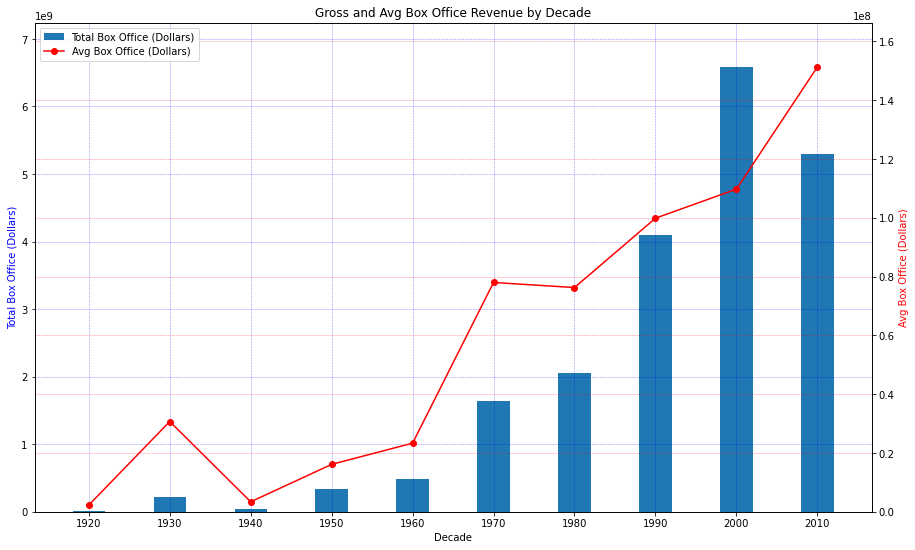

In [30]:
# Creating primary y-axis (gross_income)
fig, ax1 = plt.subplots(figsize=(15, 9))
ax1.bar(agg_decade['DECADE'], agg_decade['TOTAL_GROSS'], 
        width=0.4, align='center', label='Total Box Office (Dollars)')
ax1.set_xlabel('Decade')
ax1.set_ylabel('Total Box Office (Dollars)', color='blue')

# Changing the color and transparency (alpha) of gridlines on the primary y-axis
ax1.grid(color='blue', linestyle='--', linewidth=0.5, alpha=0.5)

# Creating secondary y-axis (avg_income)
ax2 = ax1.twinx()
ax2.plot(agg_decade['DECADE'], agg_decade['AVG_GROSS'], 
         marker='o', color='red', label='Avg Box Office (Dollars)')
ax2.set_ylabel('Avg Box Office (Dollars)', color='red')

# Changing the color and transparency (alpha) of gridlines on the secondary y-axis
ax2.grid(color='red', linestyle='--', linewidth=0.5, alpha=0.5)

# Setting the same y-axis limits for both ax1 and ax2
ax1.set_ylim(0, 1.1*max(agg_decade['TOTAL_GROSS']))
ax2.set_ylim(0, 1.1*max(agg_decade['AVG_GROSS']))

# Combining legends for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Set title
plt.title('Gross and Avg Box Office Revenue by Decade')

# Show the plot
plt.show()

In [31]:
#check top 10 directors with most movies in IMDB 250
director_movies = """
SELECT DIRECTOR,
COUNT(NAME) AS NUM_MOVIES,
SUM(GROSS) AS TOTAL_BOX_OFFICE,
AVG(GROSS) AS AVG_BOX_OFFICE,
ROUND(AVG(RATING),2) AS AVG_RATING_PER_MOVIE
FROM imdb
GROUP BY DIRECTOR
ORDER BY TOTAL_BOX_OFFICE DESC
LIMIT 10
"""

director_movies = sqldf(director_movies,locals())
director_movies

,director,NUM_MOVIES,TOTAL_BOX_OFFICE,AVG_BOX_OFFICE,AVG_RATING_PER_MOVIE
0,Christopher Nolan,7,1749080000,2.498686e+08,8.57
1,Steven Spielberg,7,1568540000,2.240771e+08,8.27
2,Peter Jackson,3,1035940000,3.453133e+08,8.87
3,J.J. Abrams,1,936660000,9.366600e+08,7.80
4,Robert Zemeckis,2,540860000,2.704300e+08,8.65
5,Martin Scorsese,7,518209999,7.403000e+07,8.30
6,Quentin Tarantino,5,464210000,9.284200e+07,8.42
7,"Roger Allers, Rob Minkoff",1,422780000,4.227800e+08,8.50
8,Lee Unkrich,1,415000000,4.150000e+08,8.30
9,James Gunn,1,389810000,3.898100e+08,7.60


In [32]:
agg_director = pd.DataFrame(director_movies)

C:\Users\jlenehan\AppData\Local\Temp\ipykernel_10076\277823237.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(agg_director['director'], rotation=-45, ha='left')


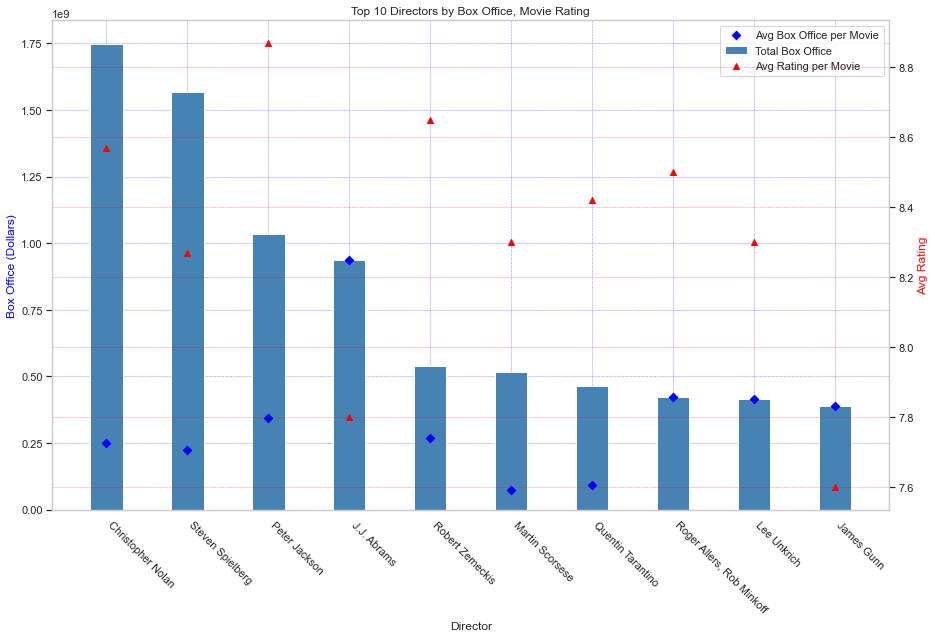

In [40]:
# Creating figure and axis
fig1, ax1 = plt.subplots(figsize=(15, 9))

#plotting bar chart of total box office
ax1.bar(agg_director['director'], agg_director['TOTAL_BOX_OFFICE'], 
        width=0.4, align='center', color='steelblue', label='Total Box Office')
ax1.set_xlabel('Director')
ax1.set_xticklabels(agg_director['director'], rotation=-45, ha='left')
ax1.set_ylabel('Box Office (Dollars)', color='blue')

# Adjusting gridlines on the primary y-axis
ax1.grid(color='blue', linestyle='--', linewidth=0.5, alpha=0.5)

#creating scatter plot of avg box office
ax1.scatter(agg_director['director'], agg_director['AVG_BOX_OFFICE'], 
         marker="D", color='blue', label='Avg Box Office per Movie')

# Creating scatter plot of avg rating on secondary axis
ax2 = ax1.twinx()
ax2.scatter(agg_director['director'], agg_director['AVG_RATING_PER_MOVIE'], 
         marker='^', color='red', label='Avg Rating per Movie')
ax2.set_ylabel('Avg Rating', color='red')

# Adjusting gridlines on the secondary y-axis
ax2.grid(color='red', linestyle='--', linewidth=0.5, alpha=0.5)

# Combining legends for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Set title
plt.title('Top 10 Directors by Box Office, Movie Rating')

# Show the plot
plt.show()

In [34]:
decade_rating_movies = """
select NAME, DECADE, RATING, GROSS
FROM imdb
ORDER BY DECADE ASC, RATING DESC
"""

decade_rating_gross = sqldf(decade_rating_movies,locals())
decade_rating_gross

,name,DECADE,rating,gross
0,Metropolis,1920,8.3,1240000
1,The Kid,1920,8.2,5450000
2,La passion de Jeanne d'Arc,1920,8.2,20000
3,Sunrise: A Song of Two Humans,1920,8.1,540000
4,The Gold Rush,1920,8.1,5450000
...,...,...,...,...
245,How to Train Your Dragon,2010,8.1,217580000
246,La La Land,2010,8.0,151100000
247,Star Wars: Episode VII - The Force Awakens,2010,7.8,936660000
248,Guardians of the Galaxy Vol. 2,2010,7.6,389810000


In [35]:
#build in percentile case when statement

actor_pop_query = """
SELECT NAME, GROSS, RUN_TIME,
CASE
WHEN RUN_TIME < 106 THEN 'Quartile 1'
WHEN RUN_TIME BETWEEN 106 AND 125 THEN 'Quartile 2'
WHEN RUN_TIME BETWEEN 125 AND 146 THEN 'Quartile 3'
WHEN RUN_TIME > 146 THEN 'Quartile 4'
END AS RUNTIME_QUARTILE
FROM imdb

ORDER BY GROSS DESC
"""

actor_pop_output = sqldf(actor_pop_query,locals())
actor_pop_output


,name,gross,run_time,RUNTIME_QUARTILE
0,Star Wars: Episode VII - The Force Awakens,936660000,138,Quartile 3
1,The Dark Knight,534860000,152,Quartile 4
2,The Dark Knight Rises,448140000,164,Quartile 4
3,The Lion King,422780000,88,Quartile 1
4,Toy Story 3,415000000,103,Quartile 1
...,...,...,...,...
245,All About Eve,10000,138,Quartile 3
246,Dial M for Murder,10000,105,Quartile 1
247,Salinui chueok,10000,131,Quartile 3
248,Le salaire de la peur,1000,131,Quartile 3


In [36]:
actor_pop_output = pd.DataFrame(actor_pop_output)

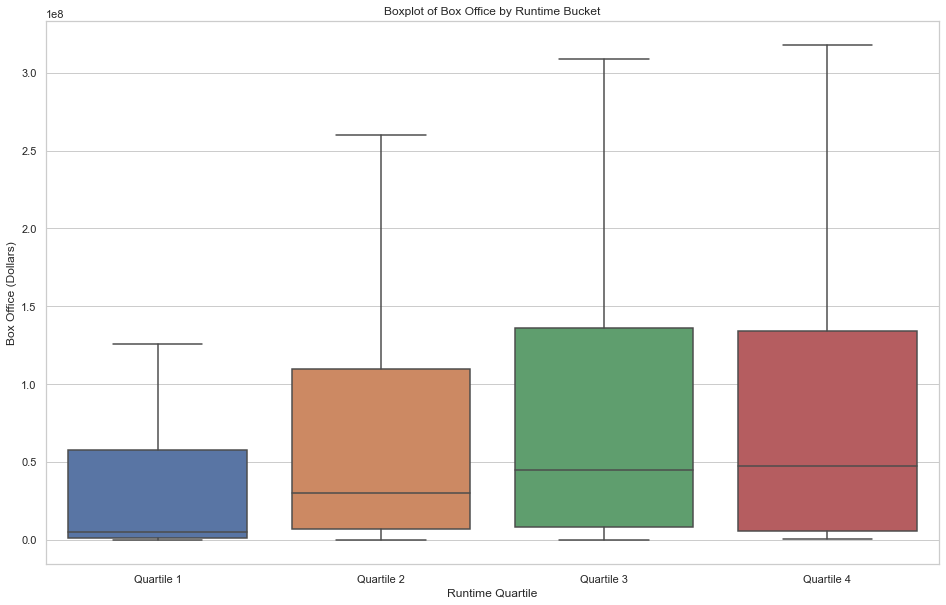

In [37]:
# Set the style for the plots
sns.set(style="whitegrid")

#Setting order of profit buckets
runtime_bucket_order = ['Quartile 1', 'Quartile 2', 
                        'Quartile 3', 'Quartile 4']

# Create the boxplot
plt.figure(figsize=(16, 10))
sns.boxplot(x='RUNTIME_QUARTILE', y='gross', 
            data=actor_pop_output, order = runtime_bucket_order, 
            showfliers=False)

# Add labels and title
plt.xlabel('Runtime Quartile')
plt.ylabel('Box Office (Dollars)')
plt.title('Boxplot of Box Office by Runtime Bucket')

# Show the plot
plt.show()